In [1]:
## Some general imports we may need:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import struct
import os
import torchvision.models as models 

from google.colab import files
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
## Check GPU availability:
gpu_boole = torch.cuda.is_available()

**Defining dataset loaders:** here, we define the dataset loaders with a specific batch size of 128 and basic tensor transformation / preprocessing:



In [12]:
## Upload meme templates
# files.upload() # meme_templates.tar.bz2
# !tar -xf meme_templates.tar.bz2
data_dir = './meme_templates'

# make subfolder with class labels
data = os.listdir(data_dir)
num_data = len(data)  # 786 meme templates
for i in range(num_data):
    if not os.path.exists(data_dir+'/'+str(i)):
        os.mkdir(data_dir+'/'+str(i))
        os.rename(data_dir+'/'+data[i], data_dir+'/'+str(i)+'/'+data[i])

transform = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor(), ])
data = dataset.ImageFolder(data_dir, transform=transform)

# shuffle train/valid/test
indices = list(range(num_data))
np.random.shuffle(indices)

# split into 0.7 test, 0.15 valid, 0.15 test
valid_split = int(np.floor(0.15 * num_data))
test_split = int(np.floor(0.15 * num_data))
train_idx, valid_idx, test_idx = indices[valid_split+test_split:], \
    indices[test_split:valid_split+test_split], \
    indices[:test_split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# load
train_loader = torch.utils.data.DataLoader(data, sampler=train_sampler, batch_size=64)
valid_loader = torch.utils.data.DataLoader(data, sampler=valid_sampler, batch_size=64)
test_loader = torch.utils.data.DataLoader(data, sampler=test_sampler, batch_size=64)

**Instantiating the model:**

In [13]:
net = inception = models.inception_v3(pretrained=True)

**Freeze all parameters but the last layer:**

In [14]:
# Freeze all model parameters
for param in net.parameters():
    param.requires_grad = False

net.AuxLogits.fc = nn.Linear(768, num_data)
net.fc = nn.Linear(2048, num_data)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

26,558,212 total parameters.
2,214,948 training parameters.


**Defining the optimizer:** we set the optimization procedure as stochastic gradient descent with various parameters. We also define our loss function.

In [15]:
if gpu_boole:
  net = net.cuda()
  
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1, momentum = 0.9)
loss_metric = nn.CrossEntropyLoss()

**Defining training and test loss and accuracy functions:** These functions will be useful in our training loop to view are training and test loss/accuracy at each epoch.

In [16]:
def eval(verbose = 1, target=''):
    correct = 0
    total = 0
    loss_sum = 0
    # which data loader
    if target == 'Train':
        data_loader = train_loader
    if target == 'Valid':
        data_loader = valid_loader
    if target == 'Test':
        data_loader = test_loader

    for images, labels in data_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()

        outputs, aux = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).detach()
        
    if verbose:
        print('%s accuracy: %f %%' % (target, 100.0 * correct.float() / total))
        print('%s loss: %f' % (target, loss_sum.cpu().data.numpy().item() / total))

    return correct.float() / total, loss_sum.cpu().data.numpy().item() / total

**Traning loop:** here, we give the training loop. A number of epochs is set. Loss is recorded and plotted at the end.

**IMPORTANT NOTE:** For re-running this code cell, if you encounter nan loss, you will need to reinstantiate your model and optimizer by re-running the "Instantiating the model:" and "Defining the optimizer:" code cells above.

Starting Training
Epoch 1 :
Train accuracy: 14.492754 %
Train loss: 0.093131
Valid accuracy: 0.000000 %
Valid loss: 0.140195
Elapsed time for epoch: 12.315232515335083 s
ETA of completion: 1.8472848773002624 minutes

Epoch 2 :
Train accuracy: 51.630436 %
Train loss: 0.063759
Valid accuracy: 0.000000 %
Valid loss: 0.155358
Elapsed time for epoch: 12.260759830474854 s
ETA of completion: 1.634767977396647 minutes

Epoch 3 :
Train accuracy: 89.673912 %
Train loss: 0.037696
Valid accuracy: 0.000000 %
Valid loss: 0.165668
Elapsed time for epoch: 12.27251648902893 s
ETA of completion: 1.4317935903867085 minutes

Epoch 4 :
Train accuracy: 96.739136 %
Train loss: 0.020496
Valid accuracy: 0.000000 %
Valid loss: 0.173087
Elapsed time for epoch: 12.310566663742065 s
ETA of completion: 1.2310566663742066 minutes

Epoch 5 :
Train accuracy: 98.731888 %
Train loss: 0.009893
Valid accuracy: 0.000000 %
Valid loss: 0.178339
Elapsed time for epoch: 12.204598188400269 s
ETA of completion: 1.017049849033355

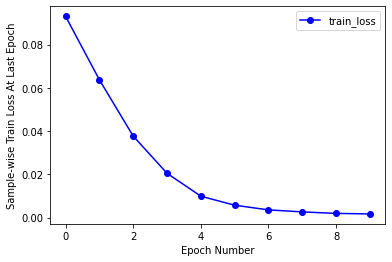

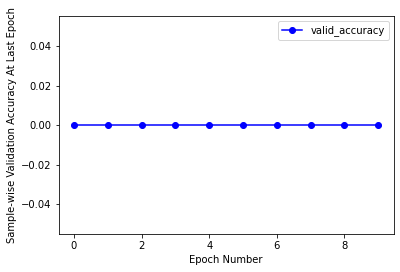

In [18]:
#re-initializing network weights:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

net.AuxLogits.fc.apply(weights_init)
net.fc.apply(weights_init)

train_loss_epoch_store = []
valid_acc_epoch_store = []

#number of epochs to train for:
epochs = 10

print("Starting Training")
#training loop:
for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (x,y) in enumerate(train_loader):
    
        if gpu_boole:
            x = x.cuda()
            y = y.cuda()

        #loss calculation and gradient update:

        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        outputs, aux = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()
                  
        ##performing update:
        optimizer.step()

    print("Epoch",epoch+1,':')
    train_acc, train_loss = eval(target='Train')
    valid_acc, valid_loss = eval(target ='Valid')

    train_loss_epoch_store.append(train_loss)
    valid_acc_epoch_store.append(valid_acc)

    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()

## Plotting epoch-wise train loss curve:
plt.plot(train_loss_epoch_store, '-o', label = 'train_loss', color = 'blue')
plt.xlabel('Epoch Number')
plt.ylabel('Sample-wise Train Loss At Last Epoch')
plt.legend()
plt.show()

## Plotting epoch-wise valid accuracy curve:
plt.plot(valid_acc_epoch_store, '-o', label = 'valid_accuracy', color = 'blue')
plt.xlabel('Epoch Number')
plt.ylabel('Sample-wise Validation Accuracy At Last Epoch')
plt.legend()
plt.show()

In [19]:
eval(target='Test')

Test accuracy: 0.000000 %
Test loss: 0.188644


(tensor(0., device='cuda:0'), 0.18864408313718617)